In [15]:
using Random, Distributions
include("Box_Neumann_To_Dirichlet.jl")

Generate_Input_Output (generic function with 1 method)

# Generate Dirichlet results for box setup

The top Neumann boundary is 
$$u_g(x) = 1_{|x - x_0| < \frac{d_0}{2}}$$

Assume the wave speed is a constant c,
Consider the Neumann boundary $\frac{\partial u}{\partial n} = u_g(x)$ on the top, and $\frac{\partial u}{\partial n} = 0$ in all 
other boundaries.
The source term is $0$.
The ouput is a $N_p \times 3 \times 4$ tensor, which contains triplet (x, Neumann result, Dirichlet result) on four boundaries.


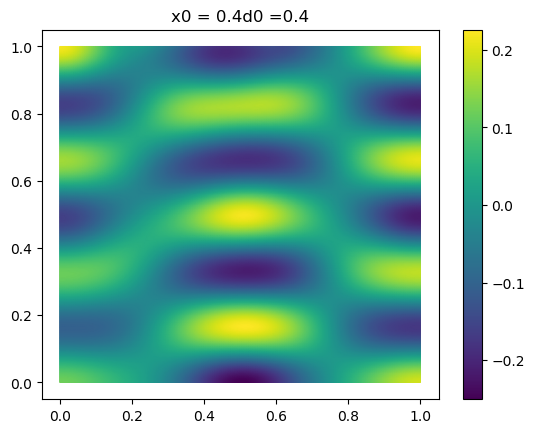

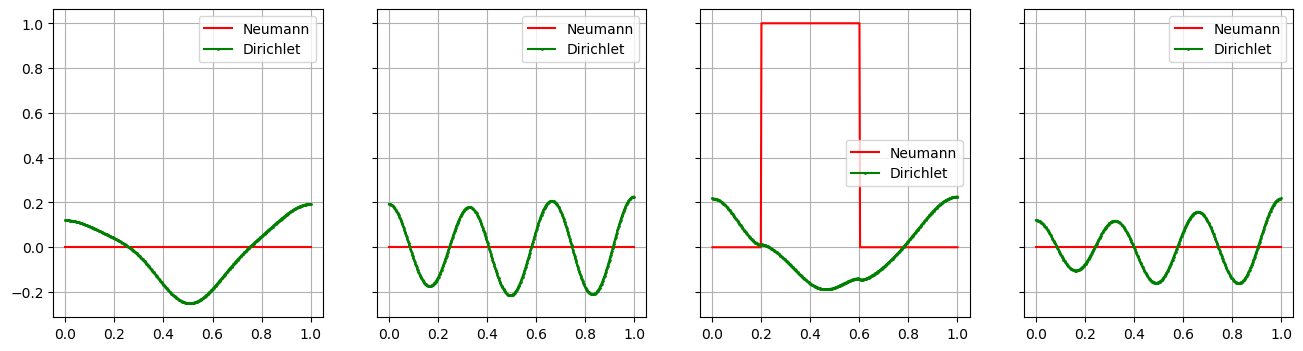

In [7]:
x0, d0 = 0.4, 0.4
c_func = (x, y)->50
ne = 200
porder = 2

data = N2D(x0, d0, c_func, ne, ne, porder, 3; visualize = true)

fig_disp, ax_disp = PyPlot.subplots(ncols = 4, nrows=1, sharex=false, sharey=true, figsize=(16,4))
markersize = 1

for bc_id = 1:4
    
    ax_disp[bc_id].plot(data[:, 1, bc_id], data[:, 2, bc_id], "-r", markersize = markersize, label="Neumann")
    ax_disp[bc_id].plot(data[:, 1, bc_id], data[:, 3, bc_id], "-go", markersize = markersize, label="Dirichlet")
    
    ax_disp[bc_id].grid()
    ax_disp[bc_id].legend()
end 
    

# Generate Dirichlet results for box setup

The top Neumann boundary is 
$$u_g(x) = 1_{|x - x_0| < \frac{d_0}{2}}$$

Assume the wave speed is a constant c,
Consider the Neumann boundary $\frac{\partial u}{\partial n} = u_g(x)$ on the top, and $\frac{\partial u}{\partial n} = 0$ in all 
other boundaries.
The source term is $0$.
The data is a $N_p \times 3 \times 4 \times N_cN_l$ tensor, number of nodal points in each boundary, triplet of (x, Neumman result, Dirichlet result), and four boundaries.


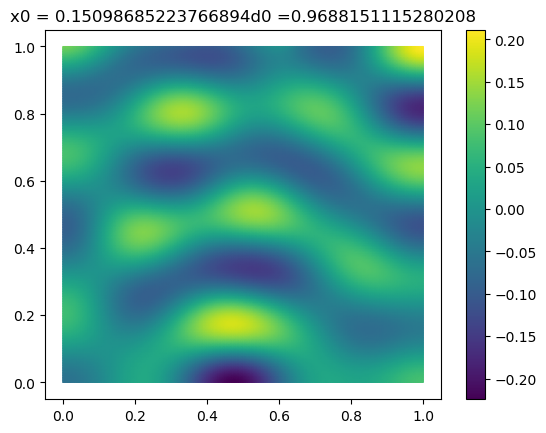

In [27]:
N_l = 500
ne = 100
porder = 2
cs = [50.0;]
x0d0s = rand(Uniform(0,1), N_l,2)
# generate Dirichlet to Neumman results output for different conditions
# data =[nodal positions, (x, ∂u∂n, u), 4 edges, experiment number]
data = Generate_Input_Output(cs,  x0d0s, ne, porder);



## Regression to obtain the matrix operator
$$
u_d = S u_n 
$$



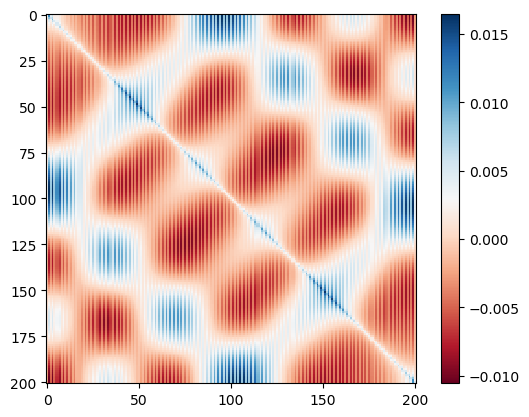

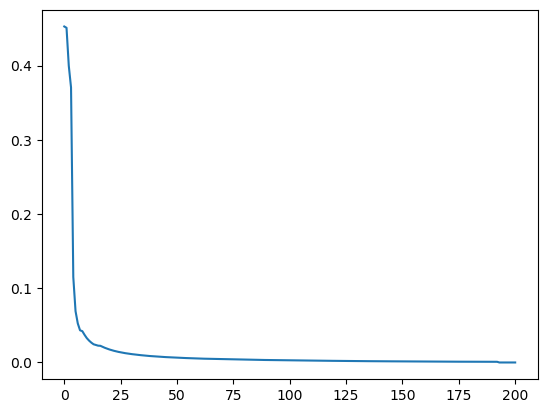

┌ Info: ("Error is ||S*u_n - u_d|| = ", 9.406412908412295e-12)
└ @ Main In[28]:9


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7ffc05b84990>

In [28]:
# data =[nodal positions, (x, ∂u∂n, u), 4 edges, experiment number]
bc_id = 3
u_n = data[:, 2, bc_id, :]
u_d = data[:, 3, bc_id, :]


S = u_d/u_n

@info "Error is ||S*u_n - u_d|| = ", norm(S*u_n - u_d)

PyPlot.figure()
PyPlot.imshow(S, cmap=:RdBu)
PyPlot.colorbar()


U, Σ, Vt = svd(S);
PyPlot.figure()
PyPlot.plot(Σ)

## No low-rank structure although the input is actually 2-dimensional

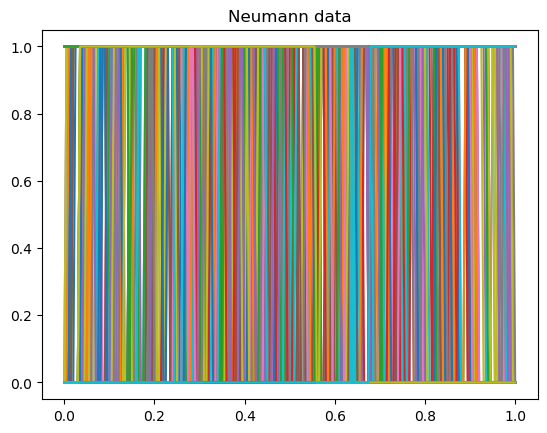

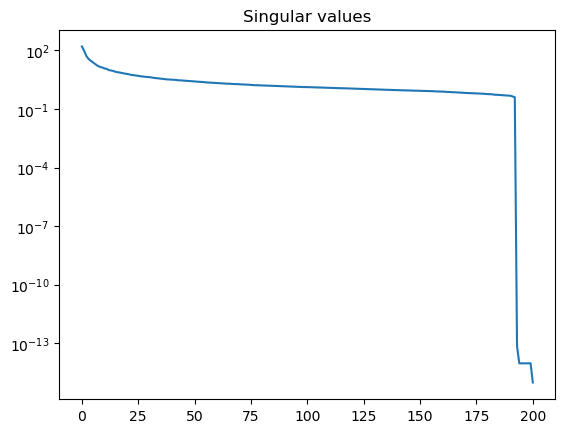

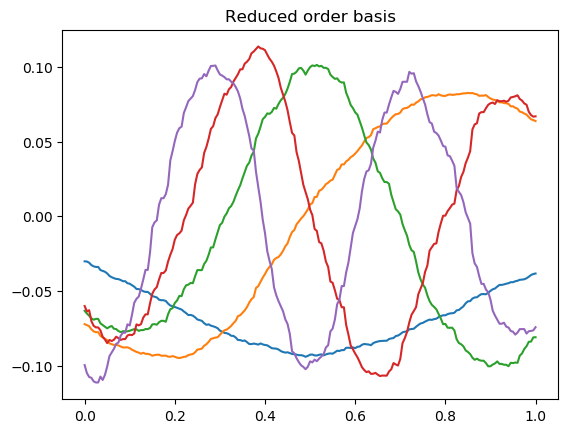

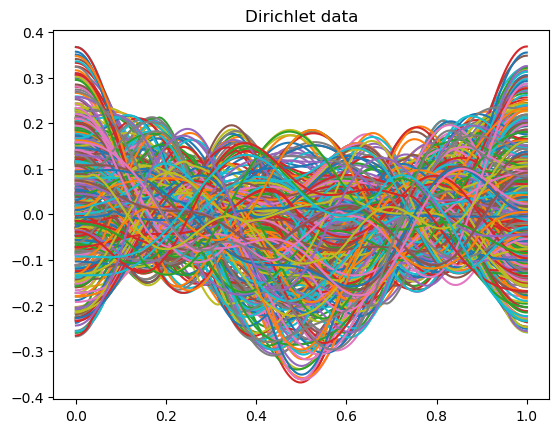

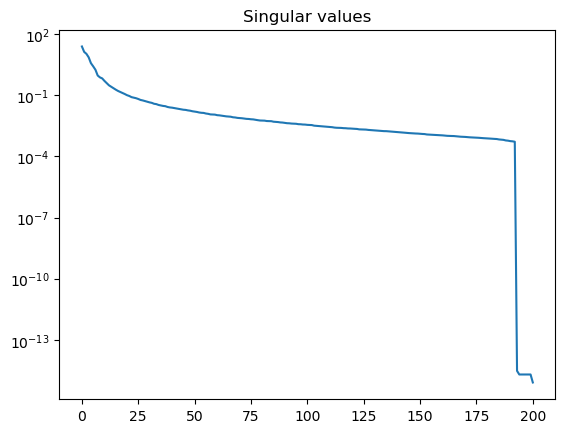

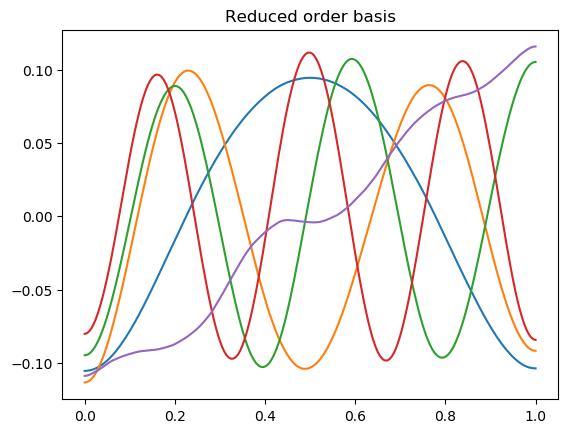

5-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7ffbee4e3a90>
 PyObject <matplotlib.lines.Line2D object at 0x7ffbee500a50>
 PyObject <matplotlib.lines.Line2D object at 0x7ffbee500c10>
 PyObject <matplotlib.lines.Line2D object at 0x7ffbee500dd0>
 PyObject <matplotlib.lines.Line2D object at 0x7ffbee500f90>

In [29]:
# consider on only the top edge
bc_id = 3
x = LinRange(0, 1, ne*porder+1)

# Neumann data
PyPlot.figure()
PyPlot.title("Neumann data")
PyPlot.plot(x, data[:, 2, bc_id, :])


PyPlot.figure()
PyPlot.title("Singular values")
U,Σ,V = svd(data[:, 2, bc_id, :])
PyPlot.semilogy(Σ)

PyPlot.figure()
trunc = 5
PyPlot.title("Reduced order basis")
PyPlot.plot(x, U[:, 1:trunc])

# Dirichlet data
PyPlot.figure()
PyPlot.title("Dirichlet data")
PyPlot.plot(x, data[:, 3, bc_id, :])


PyPlot.figure()
PyPlot.title("Singular values")
U,Σ,V = svd(data[:, 3, bc_id, :])
PyPlot.semilogy(Σ)

PyPlot.figure()
trunc = 5
PyPlot.title("Reduced order basis")
PyPlot.plot(x, U[:, 1:trunc])

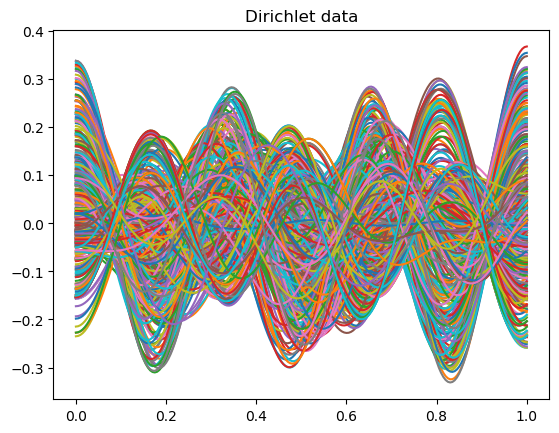

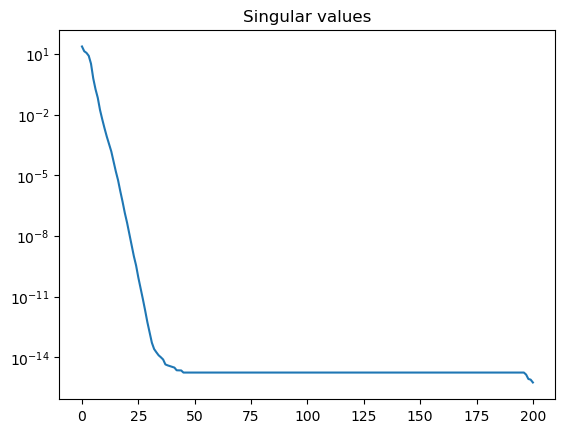

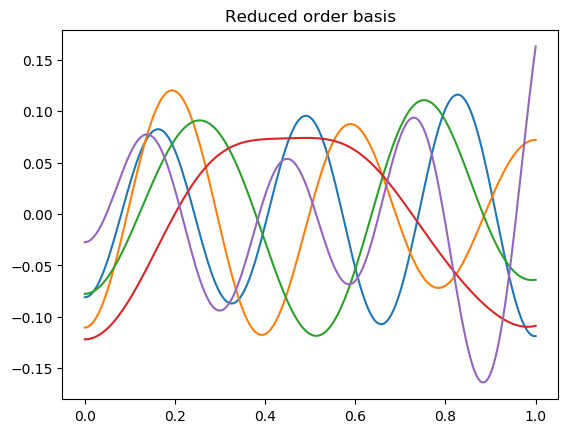

5-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7ffc050f4290>
 PyObject <matplotlib.lines.Line2D object at 0x7ffc05116250>
 PyObject <matplotlib.lines.Line2D object at 0x7ffc05116410>
 PyObject <matplotlib.lines.Line2D object at 0x7ffc051165d0>
 PyObject <matplotlib.lines.Line2D object at 0x7ffc05116790>

In [30]:
# consider on only the left edge
bc_id = 2
x = LinRange(0, 1, ne*porder+1)

# Neumann data ∂u/∂n = 0

# Dirichlet data
PyPlot.figure()
PyPlot.title("Dirichlet data")
PyPlot.plot(x, data[:, 3, bc_id, :])


PyPlot.figure()
PyPlot.title("Singular values")
U,Σ,V = svd(data[:, 3, bc_id, :])
PyPlot.semilogy(Σ)

PyPlot.figure()
trunc = 5
PyPlot.title("Reduced order basis")
PyPlot.plot(x, U[:, 1:trunc])